<img src="https://github.com/CropEvol/lecture/blob/master/textbook_2025/images/logo.png?raw=true" alt="2025年度ゲノム情報解析入門" height="100px" align="middle">

<div align="right"><a href="https://github.com/CropEvol/lecture#section2">実習表ページに戻る</a></div>

大規模なゲノムデータを用いた解析: ゲノムワイド関連解析(GWAS)
---

　今回から、ゲノム情報解析の一例として、大規模なゲノムデータセットを用いた解析を勉強・体験していきます。

大規模ゲノムデータ解析シリーズ:
- GWAS: Genome wide association study(GWAS)とは、GWAS(QTL解析)に必要な統計モデルの知識...等
- Genomic Prediction入門 : Genomic Predictionとは, 機械学習の基本, 統計モデル, 育種への応用...等々

また、今回(GWAS)のテキストのみ**PythonではなくR**を用いて行います。このノートのコードセルではRが動きます。

今回扱うGWASや統計解析に関してはPythonよりRの方がパッケージ等充実しているためです。(次回以降はPythonに戻ります。)

```
今回Rを使用する様に、ゲノム解析を行う上で使用する可能性があるプログラム等の知識は多岐に渡ります。
ゲノム解析と一言で言っても目的に応じてGUI(コマンドではなくクリック等で動かすアプリ)で完結する解析もあれば、自分でコードを書く必要がある解析もあります。
そのため、Pythonをやっておけば全てOKなんてことは無く、必要に応じてRを使用したり、Shell scriptを書いたり、場合によってはExcelでデータを処理することも当然あります。
また、この分野は進歩が速く、今使われている知識がずっと使用されるかと言うとそうとも限りません。3年後にはPythonに代わる別の言語がメジャーな言語になっていてPythonが一切使われなくなっている可能性もあります。
重要なのはその都度必要な知識を取り入れアップデートしていくことです。
(当然これはゲノム解析の分野だけではなく他の分野にも当てはまることです。)
```

# 今回の勉強内容
　このテキストでは、大規模ゲノムデータ解析シリーズの第1回として、GWASについて勉強します。

　内容は以下の通りです。

1. GWASとは？
  * 遺伝的変異と形質の関係
  * GWASの概要
  * GWASの解析手順
2. 必要となるデータセットの準備
  * 遺伝子型データと形質データ
3. GWAS入門
  * 単純な比較でGWASをやってみる
  * 単純な比較の限界
  * 代表的な統計モデルの紹介
  * イネを用いた実例
  * サンプル数やSNP数の影響
4. GWASが行えるソフトウェアの紹介

---

　一度次のコードセルを実行して、実習に必要なライブラリのインストールや、プログラム、サンプルファイルのダウンロードしてください。

In [1]:
################################
##  以下の実習の前に一度実行してください。##
################################
## Rパッケージのインストール、プログラム・サンプルファイルのダウンロード
system("wget -q -O library.tar.gz https://raw.githubusercontent.com/CropEvol/lecture/master/textbook_2023/dataset/library.tar.gz")
system("wget -q -O GWAS_sample_genotype_rice.csv https://raw.githubusercontent.com/CropEvol/lecture/master/textbook_2023/dataset/GWAS_sample_genotype_rice.csv")
system("wget -q -O GWAS_sample_phenotype_rice.csv https://raw.githubusercontent.com/CropEvol/lecture/master/textbook_2023/dataset/GWAS_sample_phenotype_rice.csv")
system("wget -q -O GWAS_sample_genotype.csv https://raw.githubusercontent.com/CropEvol/lecture/master/textbook_2023/dataset/GWAS_sample_genotype.csv")
system("wget -q -O GWAS_sample_phenotype.csv https://raw.githubusercontent.com/CropEvol/lecture/master/textbook_2023/dataset/GWAS_sample_phenotype.csv")
system("wget -q -O GWAS_sample.csv https://github.com/CropEvol/lecture/raw/refs/heads/master/textbook_2024/dataset/GWAS_sample.csv")
untar("library.tar.gz")
.libPaths("library")
# 確認
library(rrBLUP)
library(lme4qtl)

# 1. GWASとは？

## 1-1. 遺伝的変異と形質の関係
　GWAS(Genome-wide association study, ゲノムワイド関連解析)とは、多数の品種や系統を使い、表現型の多様性に影響を与える遺伝的変異を統計的に探索する事を指します。

　と言ってもピンとこないと思いますが、これまでに学習してきたQTL-seq等と似たような手法になるので、まずは復習がてら前回やったQTL-seqを元に説明していきます。

　前回はQTL-seqという、**遺伝子マッピング**（**Gene mapping**）手法について少し学びました。

遺伝子マッピングがどのような手法だったかというと、個体AとBのあいだの形質の違いを作っている遺伝子（原因遺伝子）がゲノム上のどこにあるのかを特定する手法です。

1. 個体AとBのゲノム配列を比較すると、個体間の塩基の違い（例えば、SNP; Single nucleotide polymorphism）を発見できます。しかし、個体AとBの間の比較だけでは、どの変異が個体間の形質の違いを作っているのかを特定できません。
2. そこで、個体AとBを交配し、ゲノムをシャッフルした個体集団（分離集団）を作ります。
3. 分離集団の各個体について、形質とゲノム上の各マーカーの遺伝子型も調べ、**形質と遺伝子型に連関**（**Association**）があるゲノム上の場所を探し、原因遺伝子を含むゲノム領域を特定します。

<img src="https://github.com/CropEvol/lecture/blob/master/textbook_2023/images/gene_mapping.png?raw=true" alt="gene_mapping" height="280px" align="middle">

　上述のように、**分離集団**のマーカー遺伝子型を使って遺伝子マッピングする方法を**QTL解析**（**QTL analysis**）と言いました。QTLとはQuantitative trait locus(量的形質遺伝子座)の略称です。

　QTL-seqは、QTL解析をより省力的にした方法で、次世代シーケンスデータを用いて、分離集団の一部の個体のシーケンス情報から遺伝子マッピングをおこなう手法でした。

### (参考) QTL-seqの概要

　QTL-seqでは、分離集団のうち極端な形質値をもつ個体のバルクシーケンスデータを用いて遺伝子マッピングをおこないます。バルクシーケンス中に含まれるアリルの割合（SNP-index）の推移をゲノム全体にわたって調べることで、遺伝子の位置を特定します。

<img src="https://github.com/CropEvol/lecture/blob/master/textbook_2022/images/qtlseq_overview.png?raw=true" alt="QTL-seq" height="300px" align="middle">

> <small>Takagi, H., Abe, A., Yoshida, K., Kosugi, S., Natsume, S., Mitsuoka, C., Uemura, A., Utsushi, H., Tamiru, M., Takuno, S., Innan, H., Cano, L., Kamoun, S. & Terauchi, R. (2013). [QTL‐seq: rapid mapping of quantitative trait loci in rice by whole genome resequencing of DNA from two bulked populations](https://onlinelibrary.wiley.com/doi/full/10.1111/tpj.12105). The Plant Journal, 74(1), 174-183.</small>

### GWAS

　QTL解析では、親間の形質の違いの原因となっている遺伝子の位置を探索するために、

交配による**組換え**をうまく活用して、F2集団等の分離集団からQTLの位置を検出しました。

　GWASは、分離集団に限らず、多数の品種を対象に、集団内でばらついている形質情報と密なSNPマーカー等の遺伝子型情報を得て、

形質と遺伝子型との統計的な相関関係を網羅的に探索する手法になります。

QTL解析のより網羅的・汎用的な解析と言えるかもしれません。

　F2集団では親間の変異が1度の組換えによって混ざるだけですが、自然集団では交配や組換えが繰り返し起きており、突然変異等も生じています。そのため、より多様な遺伝的変異やその変異に伴う形質の多様性が生じている可能性があります。

　そのため、GWASでは、2親間の変異だけではなく、使用した品種・系統の持つ様々な変異から形質に関与している変異を検出することになります。

<img src="https://github.com/CropEvol/lecture/blob/master/textbook_2025/images/QTL_vs_GWAS1.png?raw=true" alt="QTL_vs_GWAS1" height="350px" align="middle">

　このように比較してみると、GWASの方が様々なQTLが検出出来てメリットが多い様に思いますが、デメリットも当然あります。

　QTL解析では、A種とB種間の遺伝子型の違いだけに着目すれば良かったのですが、

GWASを行うためにはA種vsB種、B種vsC種、C種vsD種...といった様々な種間の遺伝子型の違いを捉える必要があります(下図のSNP_X)。

　それだけ変異のバリエーションが多いという事になるので、QTL解析ではざっくりとした領域毎のSNP情報で問題無かった所、GWASではシーケンスをしっかり読んで十分に密なSNPの情報が必要になります。

　特に、特定の１品種しか持たない遺伝的な変異の効果を捉える場合、分離集団を用いたQTL解析の方が適している可能性もあります。

　下図のSNP_Yの効果を調べるにはB種と他多数の種を比較するより、A種とB種を交配した集団で比較した方が確実です。

　分離集団を作ることで、SNP_YがAの個体・Gの個体がそれぞれ一定数出現する形になり、効果を確認しやすくなります。

　よって、QTL解析・GWASそれぞれにメリット・デメリットがあり適した使い分けが重要になります。

<img src="https://github.com/CropEvol/lecture/blob/master/textbook_2023/images/QTL_vs_GWAS2.png?raw=true" alt="QTL_vs_GWAS2" height="350px" align="middle">

### 1-2. もう少し具体的に
　GWASでは、上述した様に、多数の品種や系統(場合によっては分離集団も)等の集団を用いて、集団の持つ遺伝的変異それぞれについて、特定の形質に対する影響の強さを考えていきます。

<img src="https://github.com/CropEvol/lecture/blob/master/textbook_2025/images/test_prep.png?raw=true" alt="gwas_basic1" height="200px" align="middle">

例えば、下の様な遺伝子型の情報と、葉の長さのデータが得られたとしましょう。

<img src="https://github.com/CropEvol/lecture/blob/master/textbook_2024/images/GWAS_basic1.png?raw=true" alt="gwas_basic1" height="300px" align="middle">

この様な情報から、どのSNPの遺伝子型が葉の長さに影響を与えていそうかを調べていきます。

↓のファイルには10個のSNPの遺伝子型と葉の長さのデータがあります。

[GWAS_sample.xlsx](https://github.com/CropEvol/lecture/raw/refs/heads/master/textbook_2024/dataset/GWAS_sample.xlsx)

　まずは1つ目のSNPが葉の長さに影響を与えているかどうか、を調べてみましょう。

1つ目のSNPは種によって"A(アデニン)"もしくは"C(シトシン)"の遺伝子型になっています。

もしこの場所の遺伝子型が変わると葉の長さが大きく変化するのであれば、Aになっている種とCになっている種の間に葉の長さに差があるはずです。

　では皆さんの今使えるツールや知識でAになっている種とCになっている種の間に葉の長さに差があるのかを確認してみましょう。

例えばExcelで1つ目のSNPがAのデータとCのデータそれぞれの箱ひげ図を描いてみます。

Leaf列のデータを使って箱ひげ図を描き、グラフを右クリック→データの選択→横(項目)軸ラベルの編集から、SNPの遺伝子型を選びます。

<img src="https://github.com/CropEvol/lecture/blob/master/textbook_2024/images/t_test.png?raw=true" alt="t_test" height="300px" align="middle">

これで遺伝子型が変わることで葉の長さが変わるのか大まかにですが確かめることが出来ます。

では同じことをSNP2~SNP10まで1個1個やっていってみてください。

<br><br>

…というのは面倒ですね。

実際に扱うデータの場合、SNPの数は数万~数百万のスケールになります。

同じ様にポチポチExcelでやることを考えるといくら時間があっても足りません。

というわけでExcelでGWAS(というよりゲノム解析全般)をやる人はいません、プログラムで処理する必要があります。

RやPythonで遺伝子型の比較を数値的に繰り返させる必要があります。

例えばSNPの遺伝子型毎の葉の長さの平均値の差を見ていきます。

先ほどの例だと、

In [31]:
# データの読み込み
data <- read.csv("GWAS_sample.csv")

# SNP1がA(/C)のデータを取り出す
SNP1_A <- data$Leaf[data$SNP1 == "A"]
SNP1_C <- data$Leaf[data$SNP1 == "C"]

# 平均値の差を計算
mean(SNP1_A) - mean(SNP1_C)

[1] -2.478571

となります。この差が大きいほど、そのSNPの遺伝子型が葉の長さに影響を与えている可能性が高いことになります。

下記のコードを動かすと、SNPの遺伝子型が変わることで葉の長さの平均値の差が求まるので、

SNPの番号の部分の数字を変えて結果がどう変わるか見てみましょう。

In [9]:
# データの読み込み
data <- read.csv("GWAS_sample.csv")

# 検定したいSNPの番号
SNP <- "SNP1"

# SNPの遺伝子型毎に葉の長さを取り出す
SNP_genotype <- data[SNP]
Leaf_1 <- data$Leaf[SNP_genotype == unique(SNP_genotype)[1, 1]]
Leaf_2 <- data$Leaf[SNP_genotype == unique(SNP_genotype)[2, 1]]

# 平均値の差を計算する
mean(Leaf_1) - mean(Leaf_2)

[1] -2.478571

　この様な比較を全ゲノム領域のSNP1つ1つに対して行っていくことで、形質値と相関の強いゲノム領域を探索することが出来ます。

　今回の結果で言うと、8番目のSNPの遺伝子型が強く葉の長さに影響を与えているようです。

<img src="https://github.com/CropEvol/lecture/blob/master/textbook_2024/images/GWAS_basic.png?raw=true" alt="gwas_basic" height="600px" align="middle">

今回は1つの染色体にたった10個のSNPという極簡単な例を見てみましたが、

GWAS(ゲノムワイド関連解析)でやりたいことは、この様にゲノム全体の中に形質と関連しているSNP等の遺伝子型を探すことになります。



## 1-3. GWASの解析手順

それでは実際にGWASを行う際の具体的な手順を見ていきます。

GWASでは、様々な異なった遺伝的背景を持つ集団の「形質値」と「遺伝子型」のデータが必要ということでした。

GWASの流れ:

1. **集団の準備**
  * 大規模な系統(場合によっては交配集団)を集めて、異なる遺伝的背景を持つ集団を準備する
2. **形質データの測定**
  * 集団を栽培し、目的とする形質値を計測する
3. **SNP遺伝子型情報の取得**
  * ゲノム配列（参照配列）を用意する
  * 集団の各個体のシーケンスデータを得る
  * 参照配列にリードをアライメントする
  * SNPを検出し、各個体のSNPの遺伝子型情報を得る。
4. **統計解析**
  * 2, 3で得られた形質値データ、遺伝子型データを下の様なデータに整備し、統計解析を行いQTLを探索する。

<img src="https://github.com/CropEvol/lecture/blob/master/textbook_2024/images/GWAS_process.png?raw=true" alt="GWAS_process" height="200px" align="middle">

SNPの検出に関してはこれまでに既に扱ってきたので、今回は実際に扱うデータがどの様なものか説明し、

データが得られた後の統計解析の部分をやっていきます。


# 2. 必要となるデータセットの準備

当然ですが、どれだけ大規模で信頼性の高いデータを準備できるかが、GWASで良い結果を得られるかどうかを決めます。

## 2-1. 遺伝子型データ

　基本的に集団のSNPデータになります。

各SNP毎に、SNPの位置・各個体の遺伝子型の情報が入ったテーブルデータです。

QTL-seqの時にはバルクシーケンスを行いましたが、GWASでは各個体ごとにシーケンスを行いSNPを検出します。

<img src="https://github.com/CropEvol/lecture/blob/master/textbook_2024/images/GWAS_sequence.png?raw=true" alt="GWAS_sequence" height="300px" align="middle">

　バルクシーケンスでは、2回(形質値が大きい集団と小さい集団)シーケンスを行えば良かったのですが、

今回は各個体毎にシーケンスを行う必要があるので、集団サイズが大きいほどコストがかかります。

しかし、集団サイズが小さいと変異の多様性や比較に使える種数が少なくなり、十分な検定力を得られないという問題もあります。

　QTL-seqの時にリード数が少ないと、正しくSNP等の遺伝的変異の情報が読み切れないという話もありましたが、

どれだけ研究費がかけられるのか、データのサイズがどのくらい必要なのか、様々なことを考慮して研究計画をたてる必要があります。

### データフォーマットについて

先ほどExcelやRで分析を行った際は、GWASで扱うSNPの遺伝子型を"A, T, G, C"をそのまま扱っていました。

文字のデータのままだと統計的な解析を行うことが難しくなるので、解析しやすいように数字に変換して表す場合が多いです。

今回は、簡単にするために、あるSNPが"リファレンスゲノム(基準配列)の遺伝子型"か"そうでない遺伝子型か"という2種類のデータとして扱うことにします。

例えば2倍体の生物のあるSNPの遺伝子型がリファレンスゲノムでは"A"のところ、別の系統で"T"になっていた場合、

A, T という遺伝子型のデータを 0, 2 (ヘテロは1)の様に変換したりします。

<img src="https://github.com/CropEvol/lecture/blob/master/textbook_2025/images/GWAS_genotyping.png?raw=true" alt="chr to num genotype image" height="350px" align="middle">

今回は200個体の1~10番染色体にわたって位置する1000SNPの遺伝子型の情報が手に入ったとしています。

(簡略化のためヘテロ接合型は無いものとする。)

下のコードで今回扱う遺伝子型情報がどんなデータかを確認出来ます。

In [10]:
genotype = read.csv("GWAS_sample_genotype.csv", row.names=1)
genotype

,Marker,Chrom,Position,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,⋯,sample_191,sample_192,sample_193,sample_194,sample_195,sample_196,sample_197,sample_198,sample_199,sample_200
,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,1,chr01,21483,2,0,0,0,2,0,2,⋯,2,0,2,2,2,0,0,0,2,2
1,2,chr01,221351,2,0,0,0,2,0,2,⋯,2,0,2,2,2,0,0,0,2,2
2,3,chr01,402858,2,0,0,0,2,0,2,⋯,2,0,2,2,2,0,0,0,2,2
3,4,chr01,556037,2,0,0,0,2,0,2,⋯,2,0,2,0,2,0,0,0,2,2
4,5,chr01,624746,2,0,0,0,2,0,2,⋯,2,0,2,0,2,0,0,0,2,2
5,6,chr01,639118,2,0,0,0,2,0,2,⋯,2,0,2,0,2,0,0,0,2,2
6,7,chr01,697978,2,0,0,0,2,0,2,⋯,2,0,2,0,0,0,0,0,2,2
7,8,chr01,728212,2,0,0,0,2,0,2,⋯,2,0,2,0,0,0,0,0,2,2
8,9,chr01,734361,0,0,0,0,2,0,2,⋯,2,0,2,0,0,0,0,0,2,2


## 2-2. 形質データ

目的となる形質の各個体毎の計測値データです。

ただ生き物の形質値は、遺伝子の影響だけではなく環境の影響などによってぶれる可能性が考えられます。

そこで、極力そのような影響を省くことを考え、複数年の計測データなど、反復データの平均値が使われることが多いです。

今回は先ほどSNPの遺伝子型が得られている200個体について、籾数と花の色という形質のデータが得られたとします。

下のコードで今回扱う形質情報がどんなデータかを確認出来ます。

In [11]:
phenotype = read.csv("GWAS_sample_phenotype.csv", header = TRUE)
phenotype

Line,Grain.number,Flower.color
<chr>,<dbl>,<chr>
sample_1,49.42180,White
sample_2,99.83790,Red
sample_3,72.10001,White
sample_4,71.57928,White
sample_5,49.32692,White
sample_6,85.46261,Red
sample_7,51.92716,Red
sample_8,71.44643,Red
sample_9,51.51866,Red


### 2-2-1. 量的形質と質的形質

少し話がそれますが、形質には**量的形質**と**質的形質**があります。

量的形質は、葉の長さや籾数など、連続的/量的に変化する形質を持つ、複数の遺伝子の効果の総和によって支配されることが多い形質です。また、環境が形質に影響を与える場合が多いです。

質的形質は、花の色や抵抗性の有無など、１つまたは２つ程度の少数の遺伝子で決定されている形質で、不連続な階級に分類できる形質です。

**量的な**形質の場合、24cmとか320粒とか、そのまま計算に用いられそうですが、**質的な**形質だと式にあてはめられません。

そのため、GWASを用いて**質的な**形質に関連のある遺伝的領域を探したい場合、ロジスティック回帰など形質に応じた回帰モデルを使用する必要があります(後述)。

<img src="https://github.com/CropEvol/lecture/blob/master/textbook_2023/images/GWAS_phenotype.png?raw=true" alt="GWAS_phenotype" height="200px" align="middle">

(参考)
前回まで扱っていた**QTL-seq**は量的形質を対象にしています。非常に似た手法として、**Mut-map法**という手法があり、こちらは質的形質を対象としたQTL mapping手法になります。

# 3. GWASを行うための手法

　ここまでで、GWASを行うための集団のGenotypeとPhenotypeのデータが準備出来ました。

ではここからは、そのデータを元にどの様にGWASを行っていくのかという過程やその際に適用する統計モデルについて、実際に試しながらもう少し詳しく勉強していきましょう。


## 3-1. 単純な平均値の比較でGWASをやってみる

　まずは先ほどと同様に、遺伝子型間の平均値を比較することでGWASをやってみましょう。

**あるSNPの遺伝子型がA系統の遺伝子型なのかそれ以外の系統の遺伝子型なのかによって平均値にどのくらい差があるかを見てみます。**

<img src="https://github.com/CropEvol/lecture/blob/master/textbook_2025/images/GWAS_intro.png?raw=true" alt="ゲノム上の位置も図示" height="600px" align="middle">

1つのSNPに着目して平均値を比較してみましょう。

`marker = 1`の部分を`marker = 25`など、今回は1000個のSNPがあるので、1~1000の数字に変えてどのSNPの遺伝子型が形質値に影響を与えていそうか探してみましょう。

今回は遺伝子型に応じた形質値のグラフを描くコードも追加しています。

[1] "Marker 2 : 平均値の差 = -1.8372088079792"


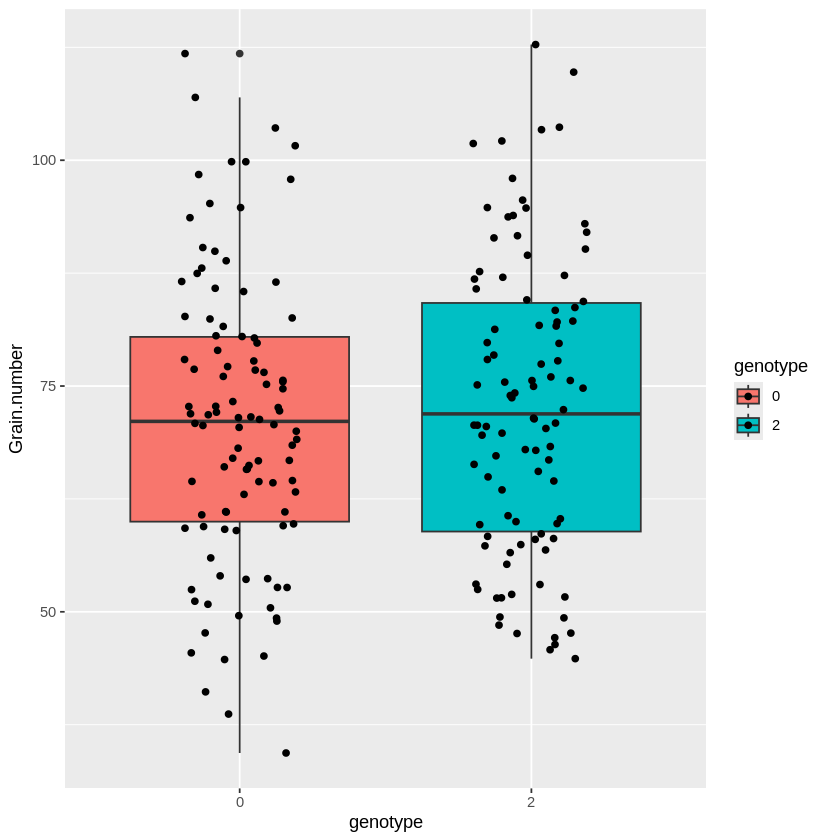

In [32]:
# 検定するSNPの番号
marker = 2

# データのフォーマットを整える
data_for_test <- data.frame(Grain.number = phenotype$Grain.number,
                                          genotype = as.character(t(genotype[genotype$Marker == marker, 4:dim(genotype)[2]])))

# 選んだSNPの遺伝子型が0の形質値
phenotype_SNP_0 <- data_for_test$Grain.number[data_for_test$genotype == 0]

# 選んだSNPの遺伝子型が2の形質値
phenotype_SNP_2 <- data_for_test$Grain.number[data_for_test$genotype == 2]

# t検定を実行
print(paste("Marker",marker,": 平均値の差 =", mean(phenotype_SNP_0) - mean(phenotype_SNP_2)))

# ボックスプロットを描くためのコード
library(ggplot2)
g <- ggplot(data_for_test, aes(x = genotype, y = Grain.number, fill = genotype))
g <- g + geom_boxplot()
g <- g + geom_jitter(width=0.2)
plot(g)

先ほどと違って今回はSNPの数が1000個あるので、1個1個数字を変えて確認していくのは手間です。

そこで、プログラムの繰り返し(`for構文`)を使うことで、全てのSNPに対して平均値の差をまとめて求めてみます。

In [33]:
#SNP1~1000までの各SNP毎に平均値の比較を行う
mean_diffs <- c()
for (i in 1:dim(genotype)[1]) {
  phenotype_SNP_0 <- phenotype$Grain.number[genotype[genotype$Marker == i, 4:dim(genotype)[2]] == 0]
  phenotype_SNP_2 <- phenotype$Grain.number[genotype[genotype$Marker == i, 4:dim(genotype)[2]] == 2]
  mean_diffs <- c(mean_diffs, mean(phenotype_SNP_0) - mean(phenotype_SNP_2))
}
GWAS_mean_diff <- data.frame(Marker=1:dim(genotype)[1], mean_diffs=mean_diffs)
GWAS_mean_diff

Marker,mean_diffs
<int>,<dbl>
1,-2.33400049
2,-1.83720881
3,-1.72833242
4,-2.17480313
5,-2.03755543
6,-1.54090821
7,-1.94486352
8,-0.83760382
9,-1.23410199


このまま1000個の値を目で見るのはしんどいので、

各SNP毎に計算された平均値の差をまとめてグラフ化して表示してみます。

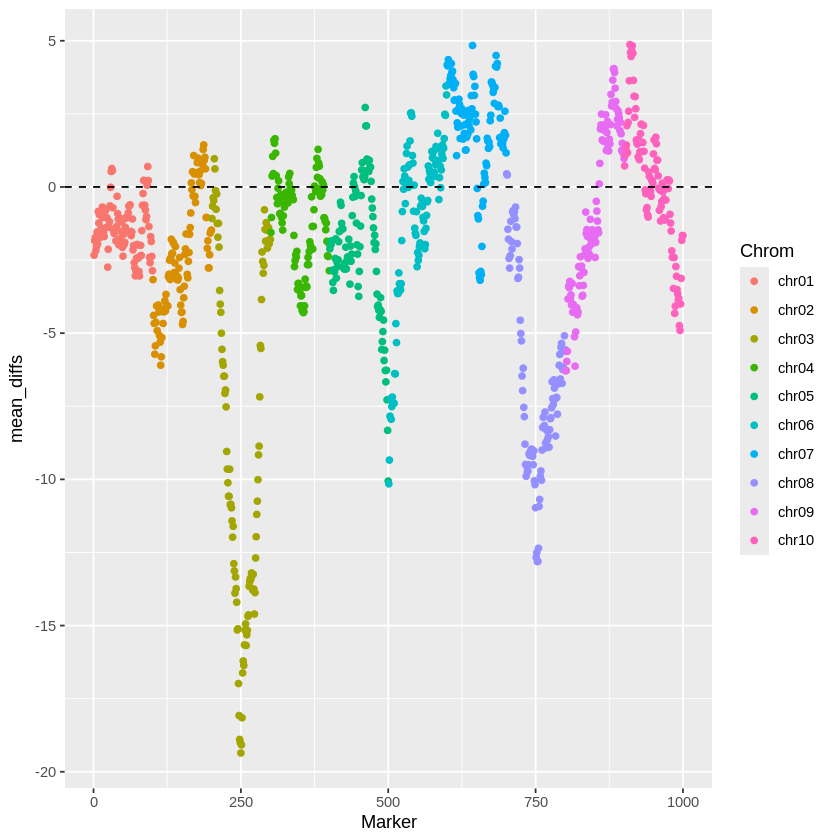

In [34]:
# 先ほど計算した 平均値の差をグラフ化
GWAS_mean_diff$Chrom <- genotype$Chrom
GWAS_mean_diff$Position <- genotype$Position

g <- ggplot(GWAS_mean_diff, aes(x = Marker, y = mean_diffs, color=Chrom))
g <- g + geom_point()
g <- g + geom_hline(yintercept = 0, linetype = "dashed")
plot(g)

X軸が各マーカー(SNP)を表しており、各染色体を色で分けています。

この様に、ゲノム全体に渡って位置するSNP毎の遺伝子型の異なる個体の平均値の差をプロットとして描写することが出来ます。

この図では、

* y軸の値がプラス側に大きい場合は、その位置のSNPの遺伝子型に変異が入ると形質にプラスの効果がある
* y軸の値がマイナス側に大きい場合は、その位置のSNPの遺伝子型に変異が入ると形質にマイナスの効果がある

ということになります。

今回のプロットを見ると250, 500, 750番目のSNPマーカー付近の遺伝子型が形質値と強く関連していそうです。

実際に250番目のSNPの遺伝子型毎にボックスプロットを描いてみると、このSNPの遺伝子型によって形質値が大きく変わっているのが分かるかと思います。

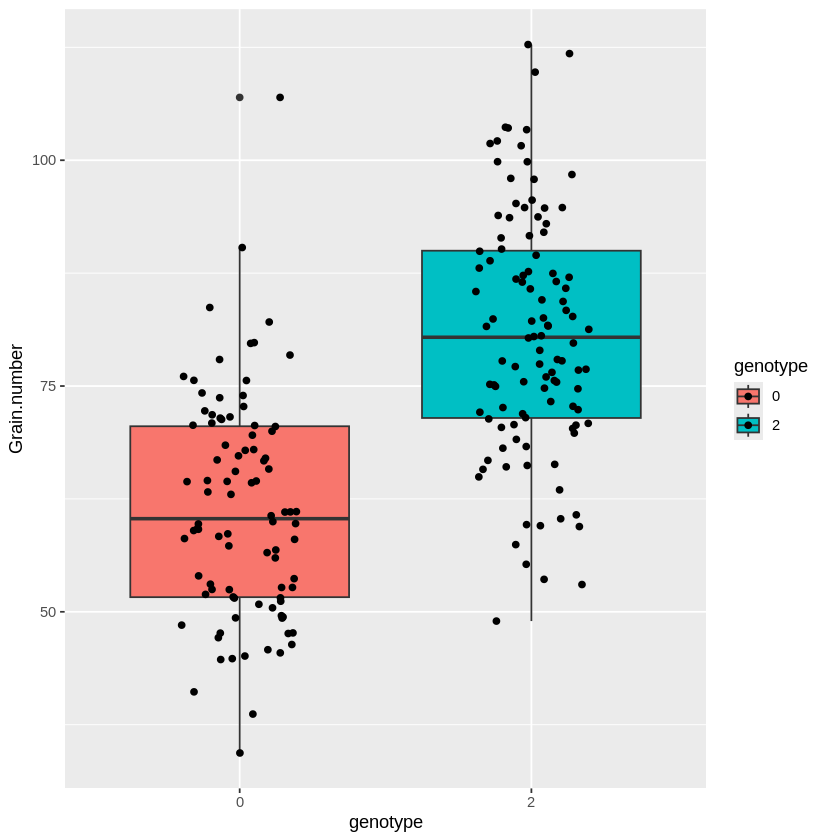

In [24]:
marker = 250

# make dataset for visualization
data_for_vis <- data.frame(Grain.number = phenotype$Grain.number,
                                         genotype = as.character(t(genotype[genotype$Marker == marker, 4:dim(genotype)[2]])))
# draw boxplot
library(ggplot2)
g <- ggplot(data_for_vis, aes(x = genotype, y = Grain.number, fill = genotype))
g <- g + geom_boxplot()
g <- g + geom_jitter(width=0.2)
plot(g)

こうした情報を元に、検出されたSNPのピーク付近に形質に効果を与える遺伝子が存在しているのではないか…といった形で研究を進めていきます。

## 3-2. 単純な比較の限界

このように、単純な平均値の比較を繰り返すことでも形質に関係していそうな遺伝領域の候補を検出できそうです。

ただ、上述したやり方では、特に現実のデータに適用するには様々な問題点があります。
* 複数の遺伝子が影響している場合、1つのSNPの遺伝子型の影響だけに着目する様なやり方で良いのか？
* GWASでは色んな種のデータを集めて使用する場合があるので、その場合はサンプル間の環境の違いや実験区域の違いなどを考慮できない
* (家畜等でGWASを行う場合)血縁関係などが考慮できた方が良い
* ...etc

今回行ったやり方だと、着目したSNPの遺伝子型の効果しか見ていないことになるので、他にもたくさん効果を持つSNPがあった場合、正しい結果が得られない可能性があります。

そこで、着目したSNPの遺伝子型だけでなく、その他の要素も組み込める、より汎用性の高いモデルが必要になってきます。

また、先ほど紹介した質的形質を扱う場合には、質的形質に適した回帰モデルを使用する必要があります。

ex)花の色の平均値…は計算できません。

<img src="https://github.com/CropEvol/lecture/blob/master/textbook_2023/images/GWAS_phenotype.png?raw=true" alt="GWAS_phenotype" height="150px" align="middle">

そのため、実際にGWASを行う際には、平均値の差の様な単純なやり方は使用されません。

次の章からは実際に利用されている代表的な統計モデルを見ていきます。

## 3-3. 代表的な統計モデルの紹介

GWASを行うための統計モデルには様々なものが存在し、今も開発が続いています。

ここでは代表的なモデルの1つとしてMixed Linear Model(MLM, 混合モデル)を紹介します。

また、対象形質が質的形質だった場合に利用することが多いロジスティック回帰についても簡単に紹介します。

(ここでは簡単な紹介だけになるので、興味がある人は自分で勉強するor生物統計学の講義を受講してみてください。)

### 3-3-1. 混合モデル

GWASでよく使用されるモデルの1つに混合モデルがあります。特に以下の様なモデルが良く使用されます。

$$
\boldsymbol{y}=W\boldsymbol{v}+X\boldsymbol{\beta}+Z\boldsymbol{u}+\boldsymbol{\epsilon}
$$

$W\boldsymbol{v}$は水準や何らかの処理の効果を固定効果として表しており、$X\boldsymbol{\beta}$は着目したSNPの効果を固定効果として表しています。$Z\boldsymbol{u}$は全ゲノム領域のポリジーン効果を変量効果として表したものになります。

つまり、個体毎の環境の違いや、他のゲノム領域の影響を考慮した上で、それでもなお着目したSNPに効果($\hat{\beta}$)があるのかを確認することが出来るモデルになっています。

<img src="https://github.com/CropEvol/lecture/blob/master/textbook_2023/images/GWAS_MLM.png?raw=true" alt="GWAS_MLM" height="450px">

この様なモデルを元に、GWASを行うソフトやプログラムがたくさん開発されています。

(参考)
* Yu et al., (2006) https://www.nature.com/articles/ng1702
* Zhang et al., (2010) https://www.nature.com/articles/ng.546

#### 固定効果と変量効果

<small>*※ 読み飛ばしてOKです。混合モデルの簡単な説明をしています。*<small>

なぜ"混合"モデルと言うのかというと、固定効果と変量効果の両者を扱うことが出来るモデルなので混合モデルと呼ばれています。

固定効果・変量効果とは何なのかというと、

* 固定効果

固定効果は水準間の比較や効果の検証を目的とする要因を固定効果として扱います。

肥料100g vs 肥料200gの効果の違いや, 投薬の有り無しによる効果の違いなどです。

今回だと、あるSNPがA系統なのかB系統なのかという違いによって生じる効果を固定効果としています。

* 変量効果

変量効果は、効果にばらつきがある、分布を持つ要因を変量効果として扱います。ランダム効果等と言われたりもします。

例えば栽培した圃場の違いの効果をモデルに組み込む場合、圃場の形質への影響はある程度ばらつくことが予想されます。

(同じ圃場Xでも、端っこの方とか真ん中あたりとかでちょっと違いますよね)。

このような場合、圃場の違いは変量効果として扱います。

<img src="https://github.com/CropEvol/lecture/blob/master/textbook_2023/images/GWAS_random.png?raw=true" alt="GWAS_random" height="400px">

* 混合モデル

この様な固定効果と変量効果、両者を含めたモデルを混合モデルといいます。

モデルの各効果の推定をするには、最良線形不偏推定値(Best Linear Unbiased Estimates, BLUE)や最良線形不偏予測値(Best Linear Unbiased Predictor, BLUP)という概念、分散成分の推定に一般的に使用される最尤推定法(Maximum Likelihood, ML)や制限付き最尤法(Restricted Maximum Likelihood, REML)と呼ばれる方法の知識が必要になりますが、今回は統計学の講義では無いので割愛します。

興味がある方は参考文献の佐々木先生の本が詳しいので見てみてください。

(参考文献)
* 久保拓弥 (2012) データ解析のための統計モデリング入門 一般化線形モデル・階層ベイズモデル・MCMC (確率と情報の科学) 岩波書店
* 佐々木義之（2007）変量効果の推定とBLUP 法．京都大学学術出版会

GWASで扱うデータには固定効果や混合効果の影響が及んでいるケースが多いので、両者を考慮できるようなモデルの開発が進められてきました。

#### 混合モデルによるGWASの例

では混合モデルを自分たちで１から作って行かないとダメかというと、そんなことは無く、混合モデルを実装したプログラムやソフトウェアがあるので、それらを利用して解析していきます。

Rのパッケージ`rrBLUP`や`GWASpoly`はこの混合モデルを実装した代表的なプログラムになります。

(参考)Endelman group (https://potatobreeding.cals.wisc.edu/software/)

今回は`rrBLUP`というパッケージを使ってGWASを行ってみましょう。

細かい使い方は説明しませんが、この様な解析プログラムの使い方は[公式のリファレンス](https://cran.r-project.org/web/packages/rrBLUP/rrBLUP.pdf)を見ると載っています。

また、大抵サンプルコードが書いてあるので、それを動かしてみたり、1行ずつ理解していく事で使い方が分かるようになっています。

今回はこちらでコードを下に準備してあります。

In [20]:
library(rrBLUP)
X <- genotype[, 4:dim(genotype)[2]]
M <- X-1
geno <- data.frame(marker=genotype$Marker, chrom=genotype$Chrom, pos=genotype$Position, M, check.names=FALSE)
pheno <- phenotype[ ,c(1,2)]
GWAS_rrBLUP <- GWAS(pheno, geno, plot=FALSE)
GWAS_rrBLUP

[1] "GWAS for trait: Grain.number"
[1] "Variance components estimated. Testing markers."


,marker,chrom,pos,Grain.number
,<int>,<chr>,<int>,<dbl>
0,1,chr01,21483,0.25884201
1,2,chr01,221351,0.12218756
2,3,chr01,402858,0.19462863
3,4,chr01,556037,0.09199573
4,5,chr01,624746,0.14433050
5,6,chr01,639118,0.04125962
6,7,chr01,697978,0.10752458
7,8,chr01,728212,0.35576487
8,9,chr01,734361,0.40154806


GWASをプログラム等で実施すると、この一番右の列の値の様に、各SNP毎に形質と関連しているか検定した統計値が得られます。

`rrBLUP`ではp値を$-log10$変換した、$-log10(p)$値が一番右の列に表示されます。

$p$値は、値が小さいほど、そのSNPの遺伝子型が形質と関連している可能性が高いことを示しています。

($p$値についても詳しくは生物統計学の講義を受講するか独学してください。)

小さいほど関連している、というとややこしいので$-log10(p)$に変換して、大きいほど形質と関連している値に変換されて表記されていることが多いです。

実際にこの$-log10(p)$値をグラフ化してみると、

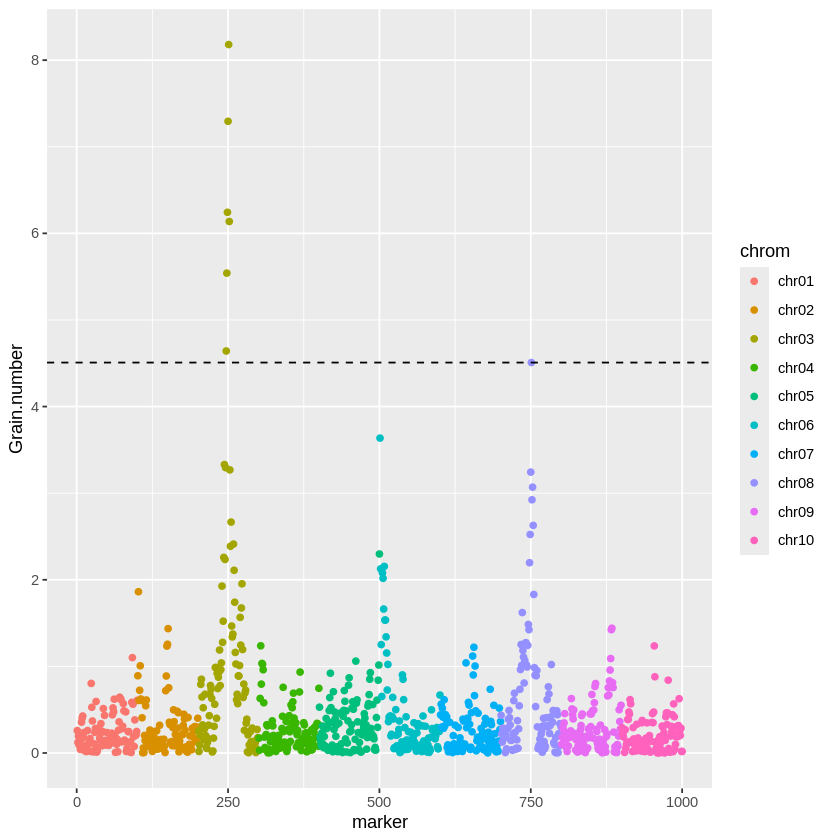

In [21]:
# calculate FDR threshold
q_values <- p.adjust(10 ** (-GWAS_rrBLUP$Grain.number), method = "BH")
FDR_threshold <- min(GWAS_rrBLUP$Grain.number[q_values < 0.01])

# draw manhattan plot
g <- ggplot(GWAS_rrBLUP, aes(x = marker, y = Grain.number, color=chrom))
g <- g + geom_point()
g <- g + geom_hline(yintercept = FDR_threshold, linetype = "dashed")
plot(g)

この様にゲノム全体に渡って位置するSNP毎の$-log10(p)$値等の統計値をプロットとして描写することになります。

このような図を**マンハッタン・プロット**(**Manhattan plot**)と呼びます。

y軸の値($-log10(p)$)が高い点程、その位置のSNPの遺伝子型が形質に大きな影響を与えていることを示しています。

#### (参考) マンハッタンプロットの点線について

マンハッタンプロットには点線があり、この点線を超えていれば、形質に関連しているSNPと言える、という一つの基準として表示してある場合が多いです。

この点線の基準がどう決められているかというと、

GWASでは、SNPの数だけ統計的な検定(関連しているかどうか確認する手法)を繰り返している形になるので、多重検定と呼ばれる問題が生じます。

統計検定を繰り返す場合は補正などをする必要があり、FDR(False discovery rate)やBonferroni補正などの手法を使って多重検定の補正を行う必要があります。

今回のマンハッタンプロットではFDR値と呼ばれる値を破線で示しており、この破線を超える統計値を示す遺伝的領域が、形質と有意に関係していると考えられることになります。

(多重検定の問題については生物統計学の講義で学ぶはずなのでここでは細かくは説明しません。取ってない方は独学してください。)

#### (参考)連鎖について

GWASを行うことで候補となる遺伝領域のピークが検出されたと思います。

大抵、ある１つのSNPだけが高く検出されるのではなく、高いSNPがいると、必然的に周囲のSNPも高くなっていることが分かります。

これは**連鎖**によって、あるSNPの近傍に位置するSNPも一緒に遺伝されることが多いため生じています。

#### 簡単なまとめ

遺伝子型データと形質データを集めて、`rrBLUP`等を使用しGWASを実施すると、

各SNP毎に$p$値などの形質と関連している可能性を表す統計値が得られます。

得られた統計値を用いてマンハッタンプロットを描くことで、形質と関連しているSNPの位置を検出します。

## 3-4. イネを用いた実例

これまではサンプルデータで手法等を確認していました。

このサンプルデータは籾数に対しては綺麗に250, 500, 750番目のSNPが、花の色には780番目のSNPが検出される様に意図的に作ったデータでした。

ここからは実際のイネの集団データを用いて、どのような解析結果になるのか確認してみましょう。

### 3-4-1. データの読み込み

今回使うデータは、イネの"ひとめぼれ"という系統に色んな系統をかけあわせた集団です。

ひとめぼれに色んなイネの系統の遺伝子が混ざっている集団になります。

<img src="https://github.com/CropEvol/lecture/blob/master/textbook_2023/images/paddy_field.png?raw=true" alt="paddy_field" height="400px">

この集団の遺伝子型情報と表現型情報を読み込みましょう。

まずは遺伝子型情報です。今回の場合も簡単に、0 = ひとめぼれ型、2 = 他の系統型、1 = ヘテロを表すことにします。

In [25]:
# Genotype情報
rice_genotype <- read.csv("GWAS_sample_genotype_rice.csv")
rice_genotype

Marker,Chrom,Position,N12_001,N12_002,N12_003,N12_004,N12_005,N12_006,N12_007,⋯,N12_146,N12_147,N12_148,N12_151,N12_152,N12_155,N12_158,N12_159,N12_161,N12_162
<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,chr01,1151,0,0,2,0,0,2,2,⋯,0,1,2,2,0,2,0,0,0,2
2,chr01,6918,0,0,2,0,0,2,2,⋯,0,1,2,2,0,2,0,0,0,2
3,chr01,17263,0,0,2,0,0,2,2,⋯,0,0,2,2,0,2,0,0,0,2
4,chr01,21547,0,0,2,0,0,2,2,⋯,0,0,2,2,0,2,0,0,0,2
5,chr01,31478,0,0,2,0,0,2,2,⋯,0,0,2,2,0,2,0,0,0,2
6,chr01,31843,0,0,2,0,0,2,2,⋯,0,0,2,2,0,2,0,0,0,2
7,chr01,67195,0,0,2,0,0,2,2,⋯,0,0,2,2,0,2,0,0,0,2
8,chr01,95019,0,0,2,0,0,2,2,⋯,0,0,2,2,0,2,0,0,0,2
9,chr01,129602,0,0,2,0,0,2,2,⋯,0,0,2,2,0,2,0,0,0,2


次に、表現型値の情報です。

今回は籾数と葉の幅をデータとして取得します。

In [26]:
rice_phenotype <- read.csv("GWAS_sample_phenotype_rice.csv")
rice_phenotype

id,Leaf.width,Grain.number
<chr>,<dbl>,<dbl>
N12_001,1.500,117.66667
N12_002,1.600,161.00000
N12_003,1.500,120.16667
N12_004,1.600,157.66667
N12_005,1.550,112.50000
N12_006,1.850,200.66667
N12_007,1.450,158.66667
N12_008,1.550,162.16667
N12_009,1.350,135.16667


### 3-4-2. 混合モデルによるGWAS

先ほどやった様に`rrBLUP`を使って混合モデルによるGWASを行ってみましょう。

`rrBLUP`は複数の形質も同時に解析してくれます。

In [35]:
library(rrBLUP)
X <- rice_genotype[, 4:dim(rice_genotype)[2]]
M <- X-1
geno <- data.frame(marker=rice_genotype$Marker, chrom=rice_genotype$Chrom, pos=rice_genotype$Position, M, check.names=FALSE)
GWAS_rice <- GWAS(rice_phenotype, geno, plot=FALSE)
GWAS_rice

[1] "GWAS for trait: Leaf.width"
[1] "Variance components estimated. Testing markers."
[1] "GWAS for trait: Grain.number"
[1] "Variance components estimated. Testing markers."


,marker,chrom,pos,Leaf.width,Grain.number
,<int>,<chr>,<int>,<dbl>,<dbl>
1,1,chr01,1151,1.0916713,0.15277015
2,2,chr01,6918,1.2475043,0.18727855
3,3,chr01,17263,1.0798920,0.15550480
4,4,chr01,21547,1.0798920,0.15550480
5,5,chr01,31478,1.0798920,0.15550480
6,6,chr01,31843,1.0798920,0.15550480
7,7,chr01,67195,1.0798920,0.15550480
8,8,chr01,95019,1.0798920,0.15550480
9,9,chr01,129602,1.0798920,0.15550480


各形質ごとに、SNP毎の$-log10(p)$値を算出しました。

### 3-4-3. マンハッタンプロットの描写

続いて、この$-log10(p)$値を基にマンハッタンプロットを描きます。

籾数に関して描くと、

,marker,chrom,pos,Grain.number
,<int>,<chr>,<int>,<dbl>
5904,5904,chr03,1377446,10.84235
5905,5905,chr03,1430488,10.29158
5906,5906,chr03,1440168,10.29158
5907,5907,chr03,1449830,10.29158
5908,5908,chr03,1459282,10.29158


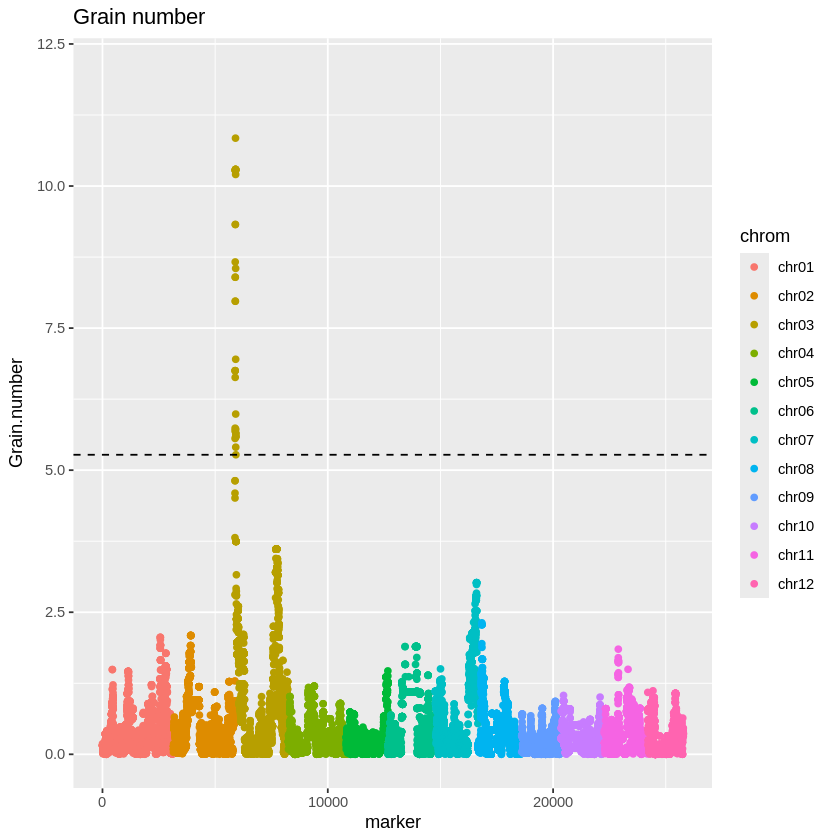

In [28]:
# calculate FDR threshold for Grain number
q_values_GN <- p.adjust(10 ** (-GWAS_rice$Grain.number), method = "BH")
FDR_threshold_GN <- min(GWAS_rice$Grain.number[q_values_GN < 0.01])
GWAS_rice[order(GWAS_rice$Grain.number, decreasing = T), ][1:5, c(1,2,3,5)]

# draw manhattan plot for Grain number
g <- ggplot(GWAS_rice, aes(x = marker, y = Grain.number, color=chrom))
g <- g + geom_point()
g <- g + geom_hline(yintercept = FDR_threshold_GN, linetype = "dashed")
g <- g + ggtitle("Grain number")
g <- g + ylim(c(0, 12))
plot(g)

葉の幅に関して描くと、

Warning message in min(GWAS_rice$Leaf.width[q_values_LW < 0.01]):
“no non-missing arguments to min; returning Inf”


,marker,chrom,pos,Leaf.width
,<int>,<chr>,<int>,<dbl>
5904,5904,chr03,1377446,4.281710
5899,5899,chr03,1248941,4.265334
5900,5900,chr03,1270252,4.265334
5901,5901,chr03,1270253,4.265334
5902,5902,chr03,1326052,4.265334


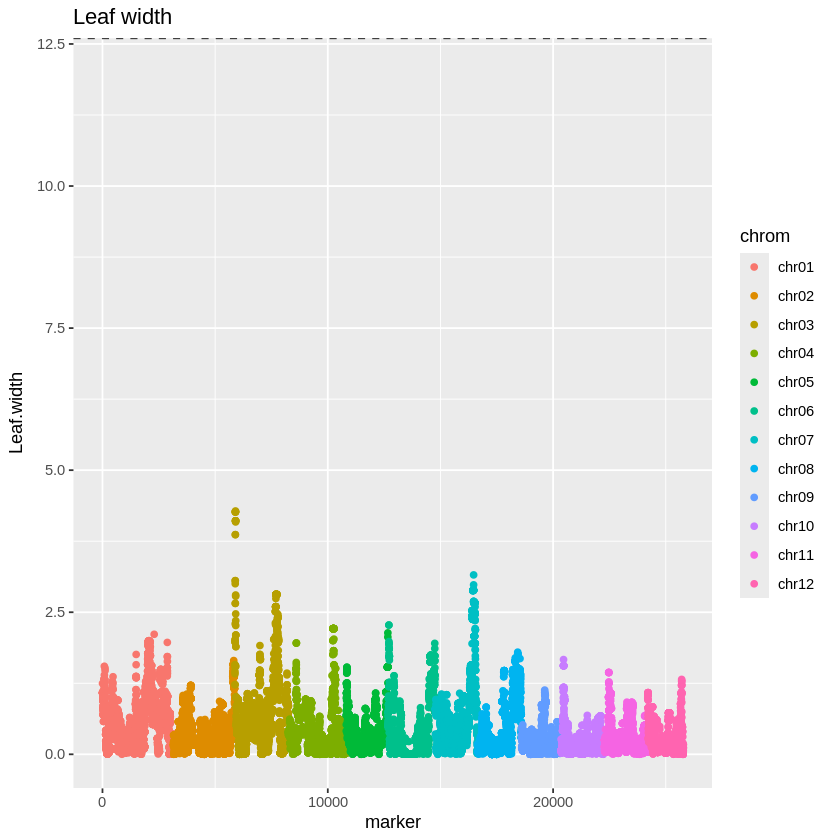

In [29]:
# calculate FDR threshold for Leaf width
q_values_LW <- p.adjust(10 ** (-GWAS_rice$Leaf.width), method = "BH")
FDR_threshold_LW <- min(GWAS_rice$Leaf.width[q_values_LW < 0.01])
GWAS_rice[order(GWAS_rice$Leaf.width, decreasing = T), ][1:5, c(1,2,3,4)]

# draw manhattan plot for Leaf width
g <- ggplot(GWAS_rice, aes(x = marker, y = Leaf.width, color=chrom))
g <- g + geom_point()
g <- g + geom_hline(yintercept = FDR_threshold_LW, linetype = "dashed")
g <- g + ggtitle("Leaf width")
g <- g + ylim(c(0, 12))
plot(g)

という形で、籾数に関しては形質に関与している領域が検出されましたが、

葉の幅に関しては形質に関与している領域が見つかりませんでした。

この原因としては

* 葉の幅は遺伝的な効果よりも環境などの影響を強く受ける形質である可能性

* 形質をコントロールしている遺伝子の数が非常にたくさんある(ポリジーン効果と呼ぶ)可能性

などが考えられます。

## 3-5. サンプル数やSNP数の影響

次に、先ほどのイネの交配集団をベースに、集団サイズが小さくなったり、検出されたSNP数が少なくなった場合に、結果がどのように変化するのか確認してみましょう。

`sample_size <- 141`の部分(集団サイズ)や`SNP_size <- 25781`の部分(SNPの数)の数字を色々変えてみてください。

[1] "GWAS for trait: Grain.number"
[1] "Variance components estimated. Testing markers."


,marker,chrom,pos,Grain.number
,<int>,<chr>,<int>,<dbl>
5904,5904,chr03,1377446,10.84235
5905,5905,chr03,1430488,10.29158
5906,5906,chr03,1440168,10.29158
5907,5907,chr03,1449830,10.29158
5908,5908,chr03,1459282,10.29158


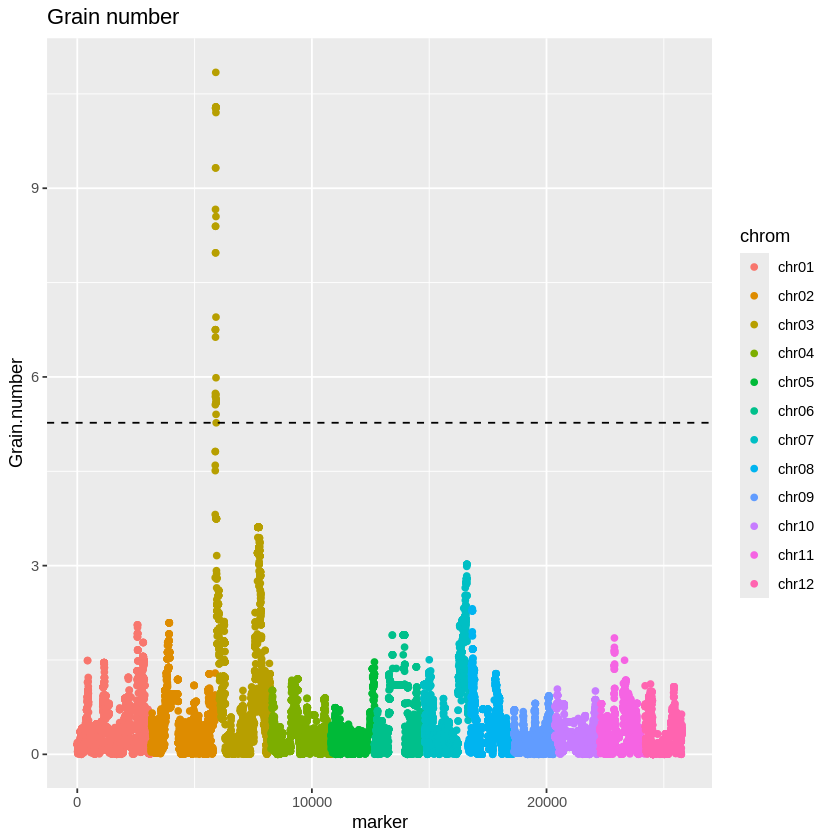

In [30]:
sample_size <- 141 # 10~141
SNP_size <- 25781 # 10~25781

# extract samples & SNPs
sample_index <- sort(sample(1:dim(rice_phenotype)[1], sample_size, replace=FALSE))
SNP_index <- sort(sample(1:dim(rice_genotype)[1], SNP_size, replace=FALSE))
tmp_genotype <- rice_genotype[SNP_index, ]
tmp_phenotype <- rice_phenotype[sample_index, c(1,3)]

# GWAS
X <- tmp_genotype[, 4:dim(tmp_genotype)[2]]
M <- X-1
geno <- data.frame(marker=tmp_genotype$Marker, chrom=tmp_genotype$Chrom, pos=tmp_genotype$Position, M, check.names=FALSE)
GWAS_rice <- GWAS(tmp_phenotype, geno, plot=FALSE)

# calculate FDR threshold for Grain number
q_values_GN <- p.adjust(10 ** (-GWAS_rice$Grain.number), method = "BH")
FDR_threshold_GN <- min(GWAS_rice$Grain.number[q_values_GN < 0.01])
GWAS_rice[order(GWAS_rice$Grain.number, decreasing = T), ][1:5, ]

# draw manhattan plot for Grain number
g <- ggplot(GWAS_rice, aes(x = marker, y = Grain.number, color=chrom))
g <- g + geom_point()
g <- g + geom_hline(yintercept = FDR_threshold_GN, linetype = "dashed")
g <- g + ggtitle("Grain number")
plot(g)

## 4. GWASが行えるソフトウェアの紹介

GWASが行えるソフトウェアやパッケージ、ライブラリ等は無数にあります。

それぞれ異なったモデルや計算手法、考慮できる要素等があり、目的に応じて最適なものを使用する必要があります。

当然考慮したい特殊な処理区等があれば自作のプログラムで解析するのも選択肢の一つです。

ソフトウェア
* TASSEL ... https://www.maizegenetics.net/tassel
* PLINK ... https://www.cog-genomics.org/plink

Rパッケージ
* rrBLUP ... https://potatobreeding.cals.wisc.edu/software/
* GWASpoly ... https://github.com/jendelman/GWASpoly
* r/qtl ... https://rqtl.org/

Pythonライブラリ
* Hail ... https://hail.is/

等々、探せばもっとたくさんあります。

このように、集団サイズが十分でないと検出力が下がったり、シーケンスが十分に出来なくて検出されたSNPの数が少ないと、候補となる領域が広くなってしまいます。

その結果、GWAS自体は行うことが出来ますが、本来形質に影響を与えている領域が検出されなかったり、意味のある結果を見逃してしまう可能性もあります。

## 5. (参考)ロジスティック回帰モデル

<small>*※ ここもややこしいので読み飛ばしてOKです。質的形質を扱う場合の簡単な説明をしています。*<small>

先ほど形質には**量的形質**と**質的形質**があるという話をしました。

ここからは形質が**質的な形質**だった場合の話をしていきます。

量的形質であれば、$21.4cm(葉の長さ)$や$12本(穂の数)$の様な形で数値として扱うことが出来ます。

$$
\boldsymbol{葉の長さ}=W\boldsymbol{v}+X\boldsymbol{\beta}+Z\boldsymbol{u}+\boldsymbol{\epsilon}
$$

しかし、質的形質は、$赤い(花の色)$といった形で数値ではない場合が多く、そのままでは計算に用いられません。

$$
\boldsymbol{花の色？}=W\boldsymbol{v}+X\boldsymbol{\beta}+Z\boldsymbol{u}+\boldsymbol{\epsilon}
$$

そのため、通常のモデルでは扱うことが難しくなります。ではどうするのかというと、

「白い花か赤い花か」や「抵抗性か感受性か」の様な質的形質は、あるクラスに分類される確率を求める形に変換します。

例えば、「SNP1の遺伝子型がTの時、赤い花になる確率はXX%」の様な形です。こうすると質的形質を数値として扱えるので

$\boldsymbol{赤い花になる確率}=W\boldsymbol{v}+X\boldsymbol{\beta}+Z\boldsymbol{u}+\boldsymbol{\epsilon}$という感じで計算出来そうです。

しかし、このまま量的形質と同じ様に解析をしていけばいいのかと言うとまだ注意点があります。

"確率"は扱いが難しい値で、

例えばSNP1の遺伝子型で花の色が変わる確率を対象に普通の回帰分析をしてみると、下図の様な問題が生じるので使用できません。

<img src="https://github.com/CropEvol/lecture/blob/master/textbook_2023/images/logistic_limit.png?raw=true" alt="logistic_regression" height="400px">

　そこで、線形回帰モデルの代わりにロジスティック回帰モデルが用いられます。

**ロジスティック回帰**（**Logisitic regression**）は、線形回帰に少し手を加えて、**あるクラスに分類される確率を求める手法**です。

<img src="https://github.com/CropEvol/lecture/blob/master/textbook_2023/images/logistic_regression.png?raw=true" alt="logistic_regression" height="400px">

　ロジスティック回帰は次の式で表されるモデルです（詳しくは「ロジスティック回帰の式を詳しく　」を参照）。

$$ z = \beta x + \epsilon $$
$$ p = \frac{1}{1+e^{-z}} $$

- 係数$\beta$をSNPの効果、説明変数$x$をSNPの遺伝子型として表しています。$\epsilon$（epsilon）は誤差（切片）です。
- $p$はあるクラスに属している確率を表しています。$e$はネイピア数（=2.7182...）です。  

　このとき、$0 ≦ p ≦ 1$なので、$-\infty < z < \infty$となり、先ほどまで扱っていた線形モデルの様に扱える様になります。

　この様にロジスティック回帰モデルをたてることで、係数$\beta$や誤差$\epsilon$が求まり、質的形質に対してもGWASが行えるようになるわけです。

#### ロジスティック回帰の式を詳しく...
<small>*※ 読み飛ばしてOKです。ロジスティック回帰の式の背景を数式を使って説明しています。*</small>

　ロジスティック回帰の式を理解するためには、**オッズ**(**odds**)から始める必要があります。

　ある事象Aが起こる確率を$p$としたとき、Aが起こらない確率は$1-p$となります。このとき、Aの起こる確率とAが起こらない確率の比は、$$\frac{p}{1-p}$$となります。これがオッズと呼ばれるもので、Aが起こる「見込み」を表しています。

確率である$p$の値は0から1の範囲しかとれませんが、オッズに変換することで$0から\infty$までの範囲に、さらに対数をとることで$-\infty$から$\infty$まで値を取ることが出来ます。

先程確率は0から1までしかとれないので回帰式が作れないという話をしましたが、対数オッズを対象にすると線形回帰で扱えそうな値になりますね。

さて、ここで最終的に知りたいことは、**データから確率$p$を推測する式**です。

$$
p = (SNPの情報などの式)
$$

　オッズの対数（**対数オッズ**）をとり、関数とみなすと、$$f(p) = \log{\frac{p}{1-p}}$$となります。これは、**ロジット関数（logit）**として知られる関数です。

　ロジット関数を逆関数にすると、$f(p)$から$p$を求める関数が得られます。
\begin{align*}
f(p) &= \log{\frac{p}{1-p}} \\
e^{f(p)} &= \frac{p}{1-p} \\
e^{f(p)} - e^{f(p)} p &= p \\
p &= {\frac{e^{f(p)}}{e^{f(p)}+1}} \\ &= \frac{1}{1+e^{-f(p)}}
\end{align*}

　ここで、$f(p) = z$ とすると、ロジスティック回帰のふたつ目の式が得られます。これは、**ロジスティック関数（logistic）**として知られる関数です。$$ p = \frac{1}{1+e^{-z}} $$この関数は、入力値$z$からAが起こる確率$p$を求める関数とみなせます。

<img src="https://github.com/CropEvol/lecture/blob/master/textbook_2019/images/logistic_curve.png?raw=true" alt="logistic_curve" height="200px">

　ロジスティック回帰は、線形回帰の式をロジスティック関数の入力$z$につなげたものです。

これは、「データx(今回だとSNPの情報)」を「Aがおこる確率$p$」に変換する式です。

$$f(p) =  z = \beta x + \epsilon $$

$$ p = \frac{1}{1+e^{-(\beta x + \epsilon)}} $$

このあたりに関しても、簡単な説明になっているので、興味のある方は各自調べてみてください。

(参考文献)

* 久保拓弥 (2012) データ解析のための統計モデリング入門 一般化線形モデル・階層ベイズモデル・MCMC (確率と情報の科学) 岩波書店

#### ロジスティック回帰による検定の例

白い花になる個体と、赤い花をつける個体から成る集団がいたとして、この質的形質である花の色と関連している遺伝領域をGWASで探してみます。

ロジスティック回帰に関しても、Rで使用可能な`glm`関数等で実装出来ますし、`lme4qtl`というパッケージでは変量効果や固定効果も踏まえたロジスティック回帰が可能です。

$$ z = W\boldsymbol{v}+X\boldsymbol{\beta}+Z\boldsymbol{u}+\boldsymbol{\epsilon} $$
$$ p = \frac{1}{1+e^{-z}} $$

(参考) [lme4qtlの論文](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2057-x)

In [ ]:
# # (計算時間がかかるので時間があれば動かしてみましょう。)

marker = 780

# convert white/red label to 0/1
pheno <- phenotype[ ,c(1,3)]
pheno["Flower.color"] <- lapply(pheno["Flower.color"], gsub, pattern="White", replacement = 0)
pheno["Flower.color"] <- lapply(pheno["Flower.color"], gsub, pattern="Red", replacement = 1)
pheno$Flower.color <- as.integer(pheno$Flower.color)

# # read genotype_data & generate variance-covariance matrix
# M <- t(geno[, -c(1:3)])
# K <- A.mat(M,shrink=FALSE)

# # statistical test by logistic regression
# SNP_geno <- t(geno[marker, -c(1:3)])
# colnames(SNP_geno) <- "SNP"
# SNP_geno <- cbind(Line = rownames(SNP_geno), SNP_geno)
# tmp_pheno <- merge(pheno, SNP_geno, by="Line")
# trait <- "Flower.color"
# model1_formula <- as.formula(paste0(trait, " ~ (1|Line)"))
# model1 <- relmatGlmer(model1_formula, tmp_pheno, relmat = list(Line = K), family = binomial)
# model2_formula <- as.formula(paste0(trait, " ~ SNP + (1|Line)"))
# model2 <- relmatGlmer(model2_formula, tmp_pheno, relmat = list(Line = K), family = binomial)
# print(model2)
# # maximum likelihood test (model1 vs model2)
# print(paste("p値 =", anova(model1, model2)[2, 8]))

今回のサンプルデータは780番目のSNPが花の色に強い影響を与えるようなデータになっているので、上記のコードを動かすと780番目のSNPに有意な効果が認められると思います。

In [ ]:
# 780番目のマーカーの遺伝子型毎のクロス集計
SNP <- 780
summary_table <- data.frame(table(phenotype$Flower.color, t(genotype[SNP, 4:dim(genotype)[2]])))
colnames(summary_table) <- c("Flower.color", "Marker780", "The number of sample")
summary_table

# まとめ

　今回、GWASの概要と解析の流れをみてきました。

GWASは関心のある形質にどのような遺伝子が影響を与えているのか調べるために、非常によく用いられています。

皆さんの中でも、ゲノム解析を主な研究手法としなくても、今後原因遺伝子の探索のきっかけとしてGWASを行う方はたくさんいると思います。


また、ポピュラーな手法なので、GWASを行うための解析プログラムやパッケージが大量に存在しています。

もちろん適切な手法やモデルをたててGWASを行うことは大切ですが、

この様な大規模なデータを用いた解析の場合は、データのサイズと質が何よりも大事です。

望ましい結果が得られない時に、手法を色々変えて無理やり検出させるような人がいますが、

「どれだけのサイズのデータがあれば自分の見たいものが検出できるのか」という点をまず第１に考える必要があるでしょう。

<div align="right"><a href="https://github.com/CropEvol/lecture#section2">実習表ページに戻る</a></div>